In [15]:
import json
import os
import sys
from collections import Counter, OrderedDict
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd
import yaml

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids import BIDSPath
from mne_bids.read import read_raw_bids
from mne_bids.tsv_handler import _from_tsv
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

if os.path.abspath("../io") not in sys.path:
    sys.path.append(os.path.abspath("../io"))

from read import read_dataset, read_label, read_trial, get_trial_info, _get_bad_chs
from utils import NumpyEncoder
from experiments import cv_fit, run_classifier_comparison

from plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices,
    plot_accuracies,
    plot_roc_aucs,
    plot_event_durations,
    plot_event_onsets
)

plt.style.use(['science', 'ieee', 'no-latex'])
plt.rcParams["font.family"] = "sans-serif"
# sns.set_palette("Set2")

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
with open(Path(os.path.abspath('')) / "config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath('')) / "metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

subjects = metadata["subjects"]

bids_root = Path(config["bids_root"])
results_path = Path(config["results_path"])

## Plot distribution of anatomy

In [5]:
channels = []
path_identifiers = dict(
    subject=subjects[0],
    session="efri",
    task="move",
    acquisition="seeg",
    run="01",
    suffix="ieeg",
    extension=".vhdr",
    root=bids_root
)
for subject in subjects:
    path_identifiers["subject"] = subject
    path_identifiers["extension"] = ".tsv"
    bids_path = BIDSPath(**path_identifiers)
    bids_path.update(suffix="channels")
    bads = _get_bad_chs(bids_path)
    
    tmp = _from_tsv(bids_path)
    tmp = [
        (name, anat, subject) 
        for (name, anat) in zip(tmp["name"], tmp["anat"]) 
        if name not in bads
    ]

    channels.extend(tmp)

channels = pd.DataFrame(channels, columns=["name", "anat", "subject"])
channels.head()
sorted_channels = channels.sort_values(["anat", "subject"])

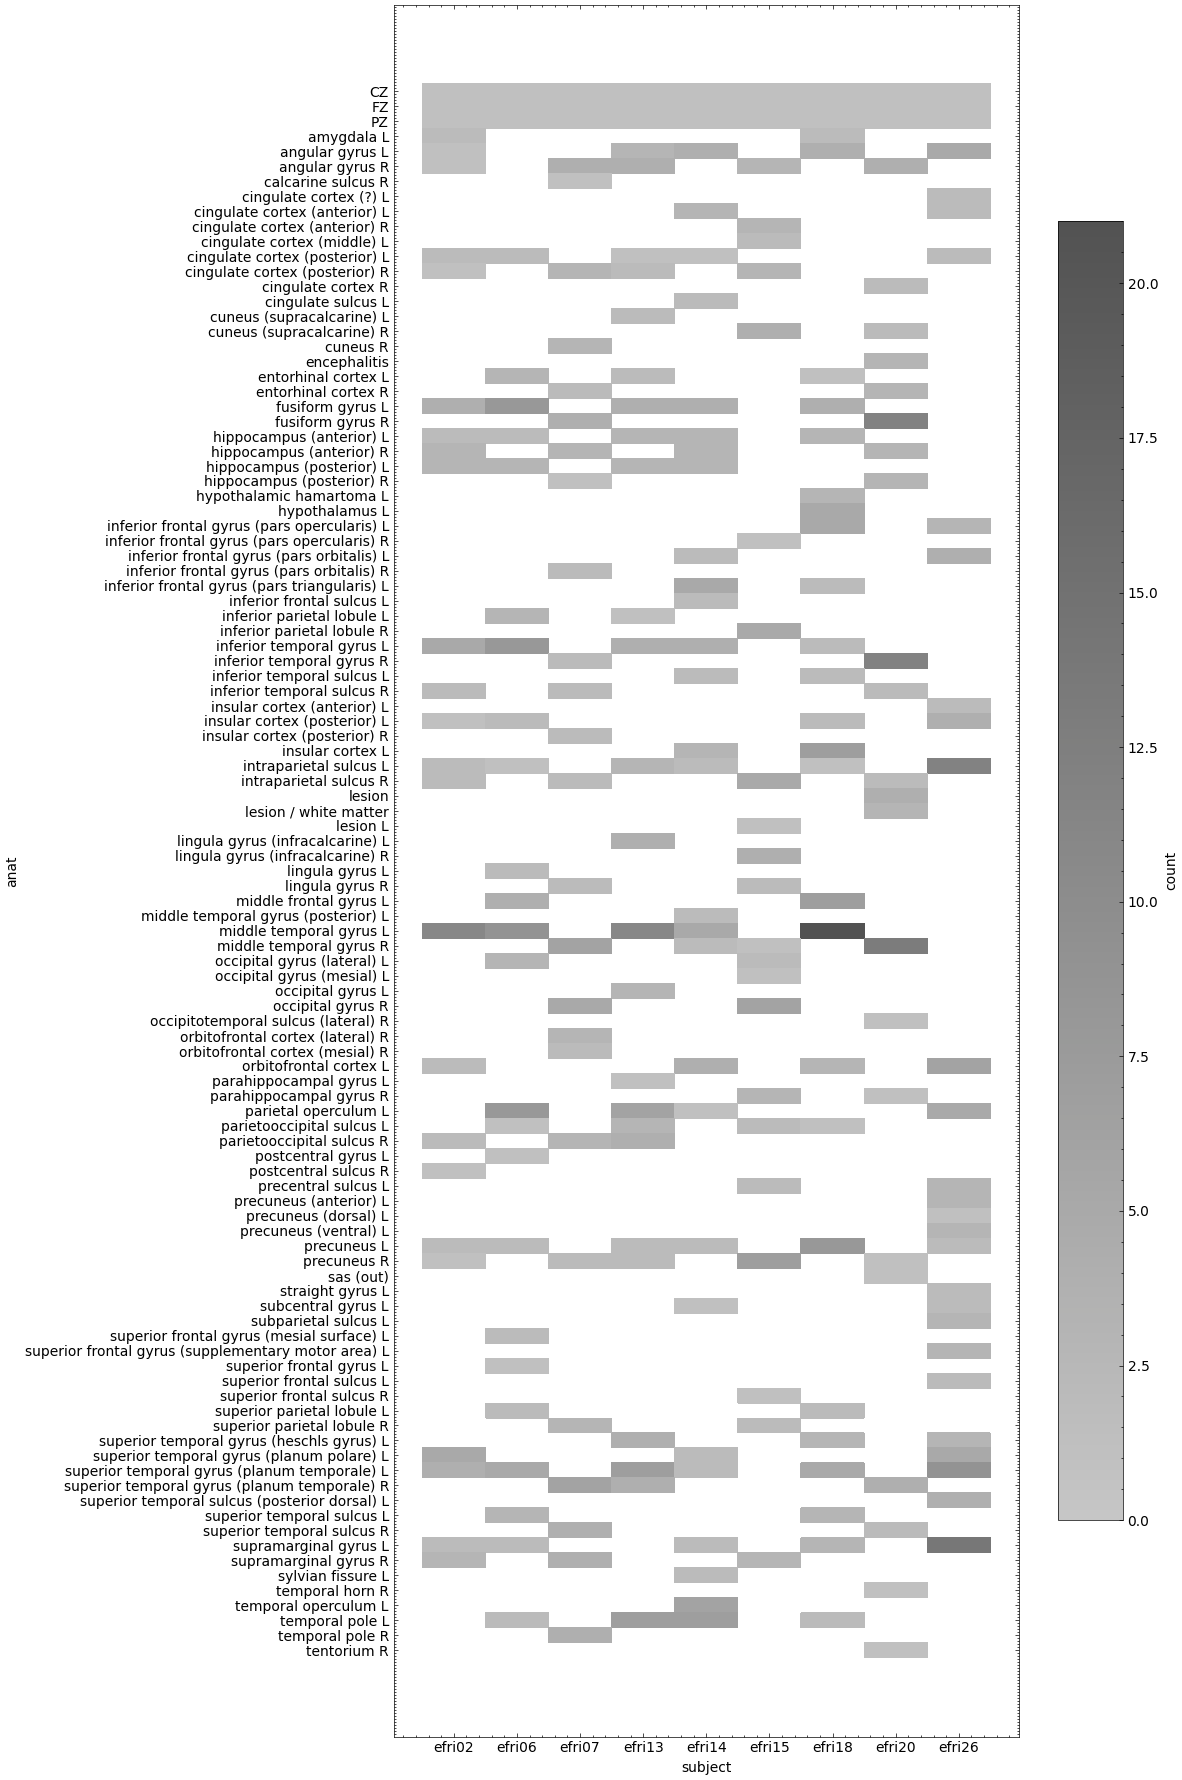

In [6]:
fig, ax = plt.subplots(dpi=100, figsize=(12, 18))

sns.histplot(
    data=sorted_channels, x="subject", y="anat", 
    cbar=True, cbar_kws=dict(shrink=.75, label="count"), ax=ax,
)
fig.tight_layout();

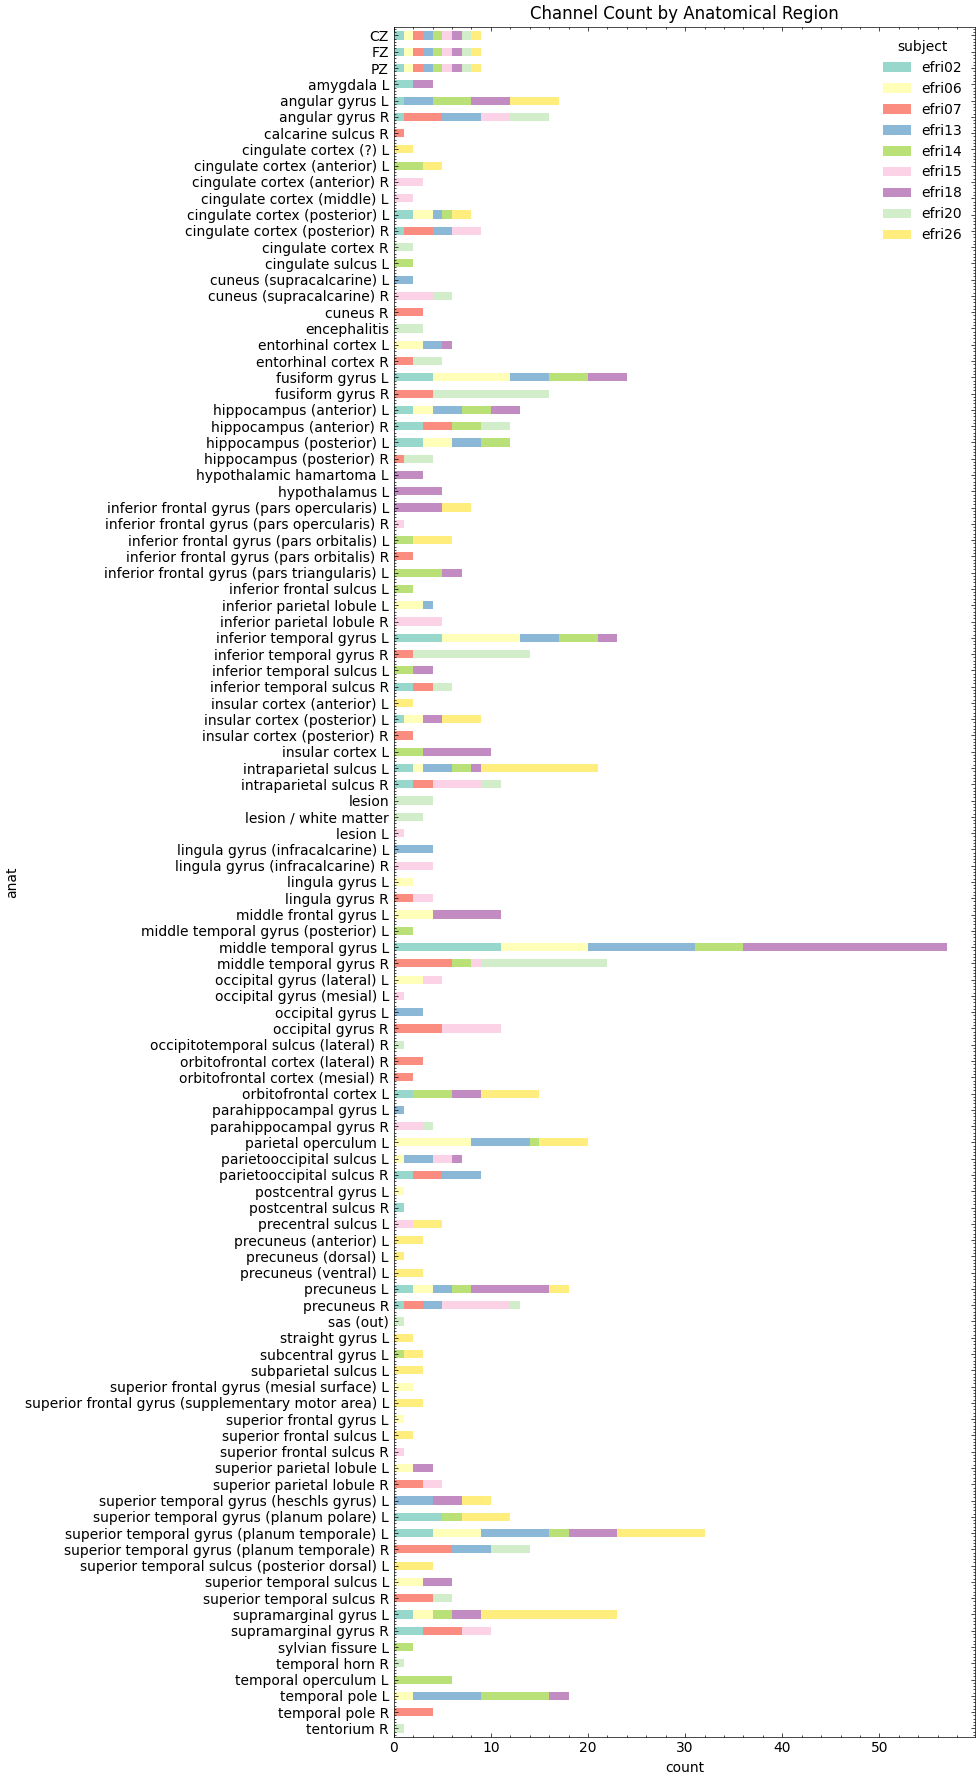

In [7]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 18))

df_plot = sorted_channels.groupby(['anat', 'subject']).size().reset_index().pivot(columns='subject', index='anat', values=0)
df_plot = df_plot.sort_values('anat', ascending=False)  # To get y-axis into the same order as above
df_plot.fillna(0)
df_plot.plot(kind="barh", stacked=True, colormap="Set3", alpha=0.9, ax=ax)
ax.set(xlabel="count", ylabel="anat", title="Channel Count by Anatomical Region")
fig.tight_layout();

## EFRI14

In [10]:
bids_root = Path("/Volumes/mac/research/data/efri/")

tmin, tmax = (-0.75, 0.5)

derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "band-pass=1-1000Hz-downsample=500"
)

# subject identifiers
subject = "efri14"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [11]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Out of 163 trials, there were 154 successful trials in /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 163 trials, there were 154 successful trials in /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading /Volumes/mac/research/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=0.5/band-pass=1-1000Hz-downsample=500/efri14/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...     498.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Dropped 26 epochs: 14, 16, 17, 20, 21, 27, 28, 29, 31, 33, 54, 63, 79, 84, 87, 91, 110, 118, 123, 125, 132, 135, 138, 140, 141, 148


In [2]:
def plot_epochs(epochs, labels, picks=None):

    drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
    label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

    epochs_by_direction = {}
    for k, v in drop_inds.items():
        tmp = epochs.copy()
        tmp.drop(v)
        epochs_by_direction[k] = tmp

    for k, ep in epochs_by_direction.items():
        fig = ep.plot(
            picks=picks,
            scalings=dict(seeg=1e2), 
            n_epochs=5,
            show=False,
            title=label_names[k],
        )
        fig.suptitle(label_names[k])
        fig.set_size_inches(18, 4, forward=True)
        plt.show()

    for i, (k, ep) in enumerate(epochs_by_direction.items()):
        ep.plot_image(
            picks=picks,
            scalings=dict(seeg=1e-6),
            title=f"{label_names[k]}: {picks}"
        )

Dropped 96 epochs: 0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 28, 32, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127
Dropped 98 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 74, 76, 77, 78, 79, 81, 83, 84, 86, 90, 91, 92, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127
Dropped 93 epochs: 1, 2, 3, 4, 5, 7, 9, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 41, 42, 44, 45, 46, 49, 52, 54, 56, 5

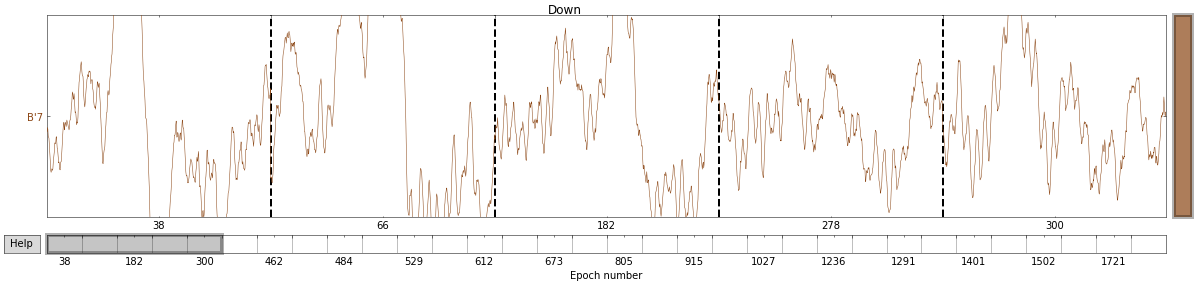

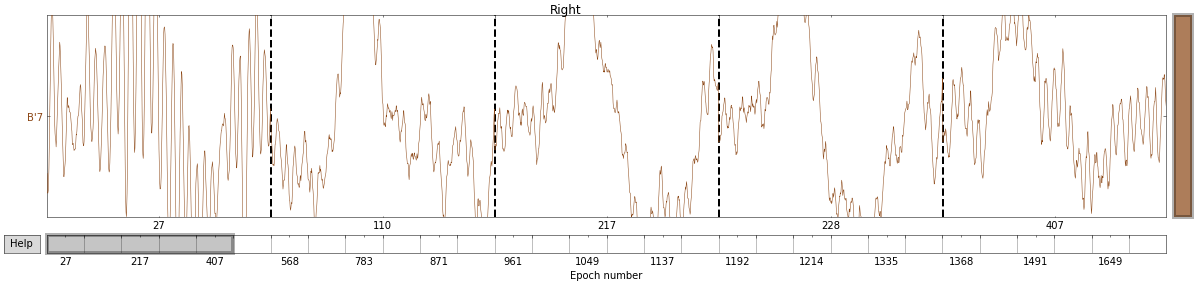

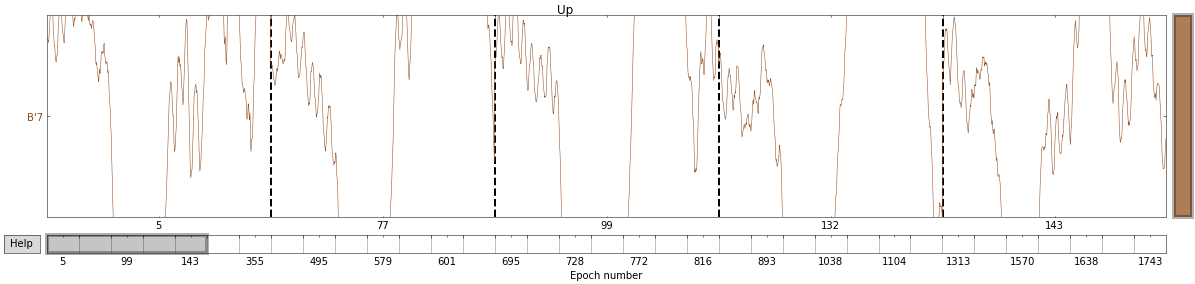

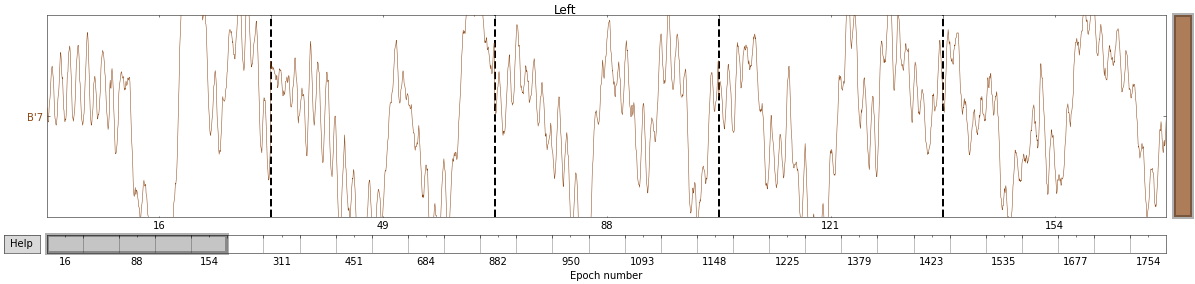

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


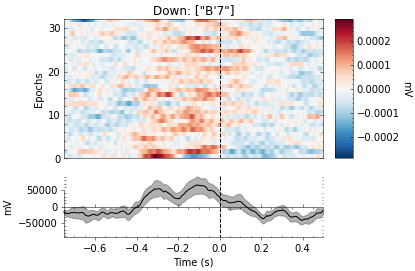

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


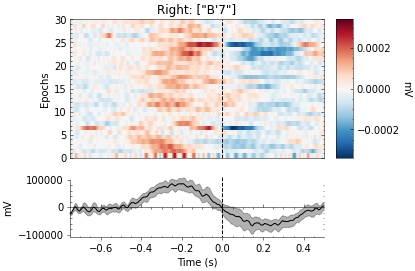

Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


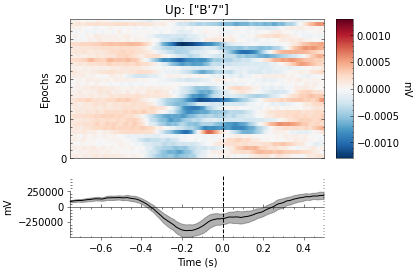

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


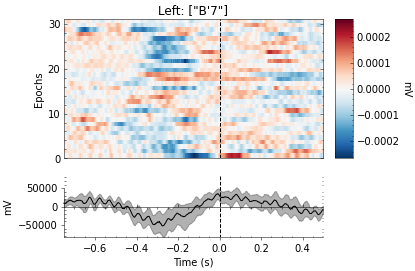

In [12]:
picks = ["B'7"]
plot_epochs(epochs, labels, picks=picks)

In [13]:
bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
bids_path.update(suffix="channels")
bads = _get_bad_chs(bids_path)

tmp = _from_tsv(bids_path)
tmp = [
    (name, anat) 
    for (name, anat) in zip(tmp["name"], tmp["anat"]) 
    if name not in bads
]

channels = pd.DataFrame(tmp, columns=["name", "anat"])
sorted_channels = channels.sort_values(["anat"])
sorted_channels.head()

name             anat
82  REF2               CZ
81  REF1               FZ
83     E               PZ
71  Y'10  angular gyrus L
72   Y'9  angular gyrus L

In [14]:
sorted_channels[sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")]

name                                 anat
70  X'1                     insular cortex L
57  T'1                     insular cortex L
52  R'1                     insular cortex L
15  F'9  middle temporal gyrus (posterior) L
16  F'8  middle temporal gyrus (posterior) L
0   B'8              middle temporal gyrus L
1   B'7              middle temporal gyrus L
2   B'6              middle temporal gyrus L
6   C'8              middle temporal gyrus L
7   C'7              middle temporal gyrus L
77   B6              middle temporal gyrus R
76   B7              middle temporal gyrus R

In [15]:
anat = sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")
picks = list(sorted_channels[anat]["name"])
epochs_anat = epochs.pick_channels(picks)

In [17]:
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

### Shuffled vs Unshuffled (Time Domain)

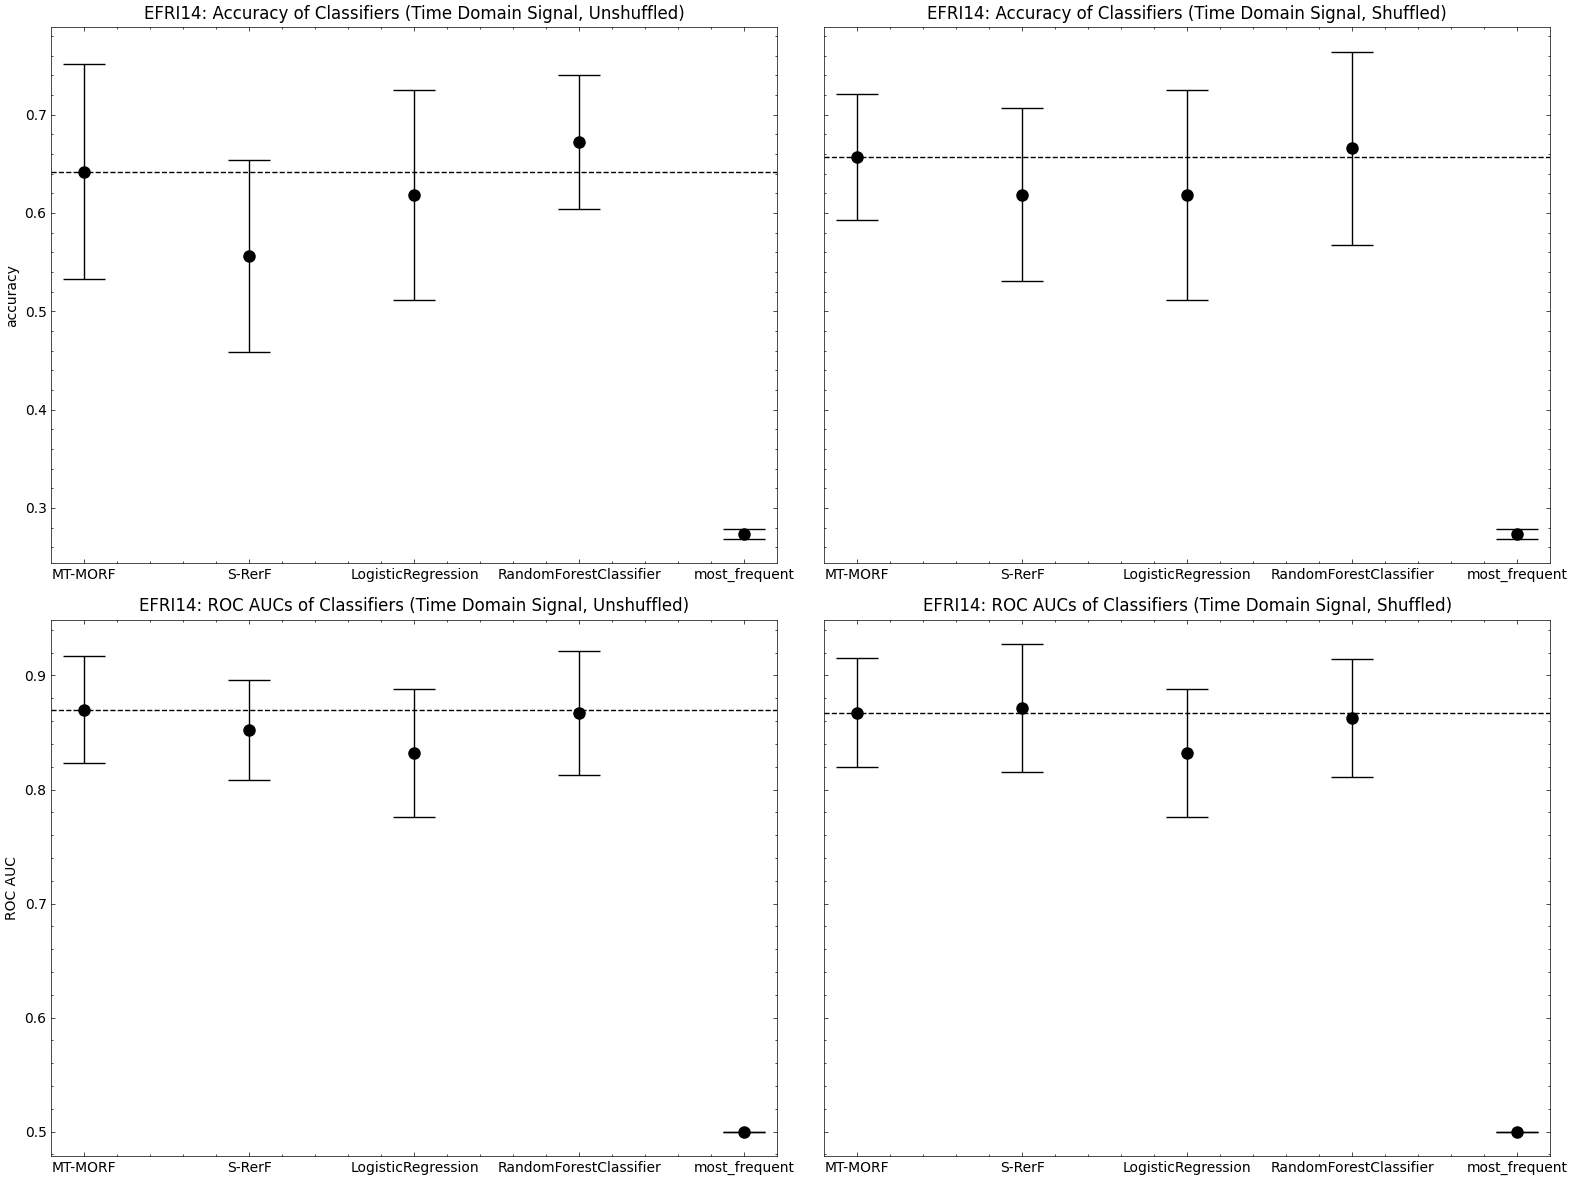

In [18]:
## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=False, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=True, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Unshuffled)")

plot_accuracies(clf_scores_shuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, Averaged)

Not setting metadata
Not setting metadata


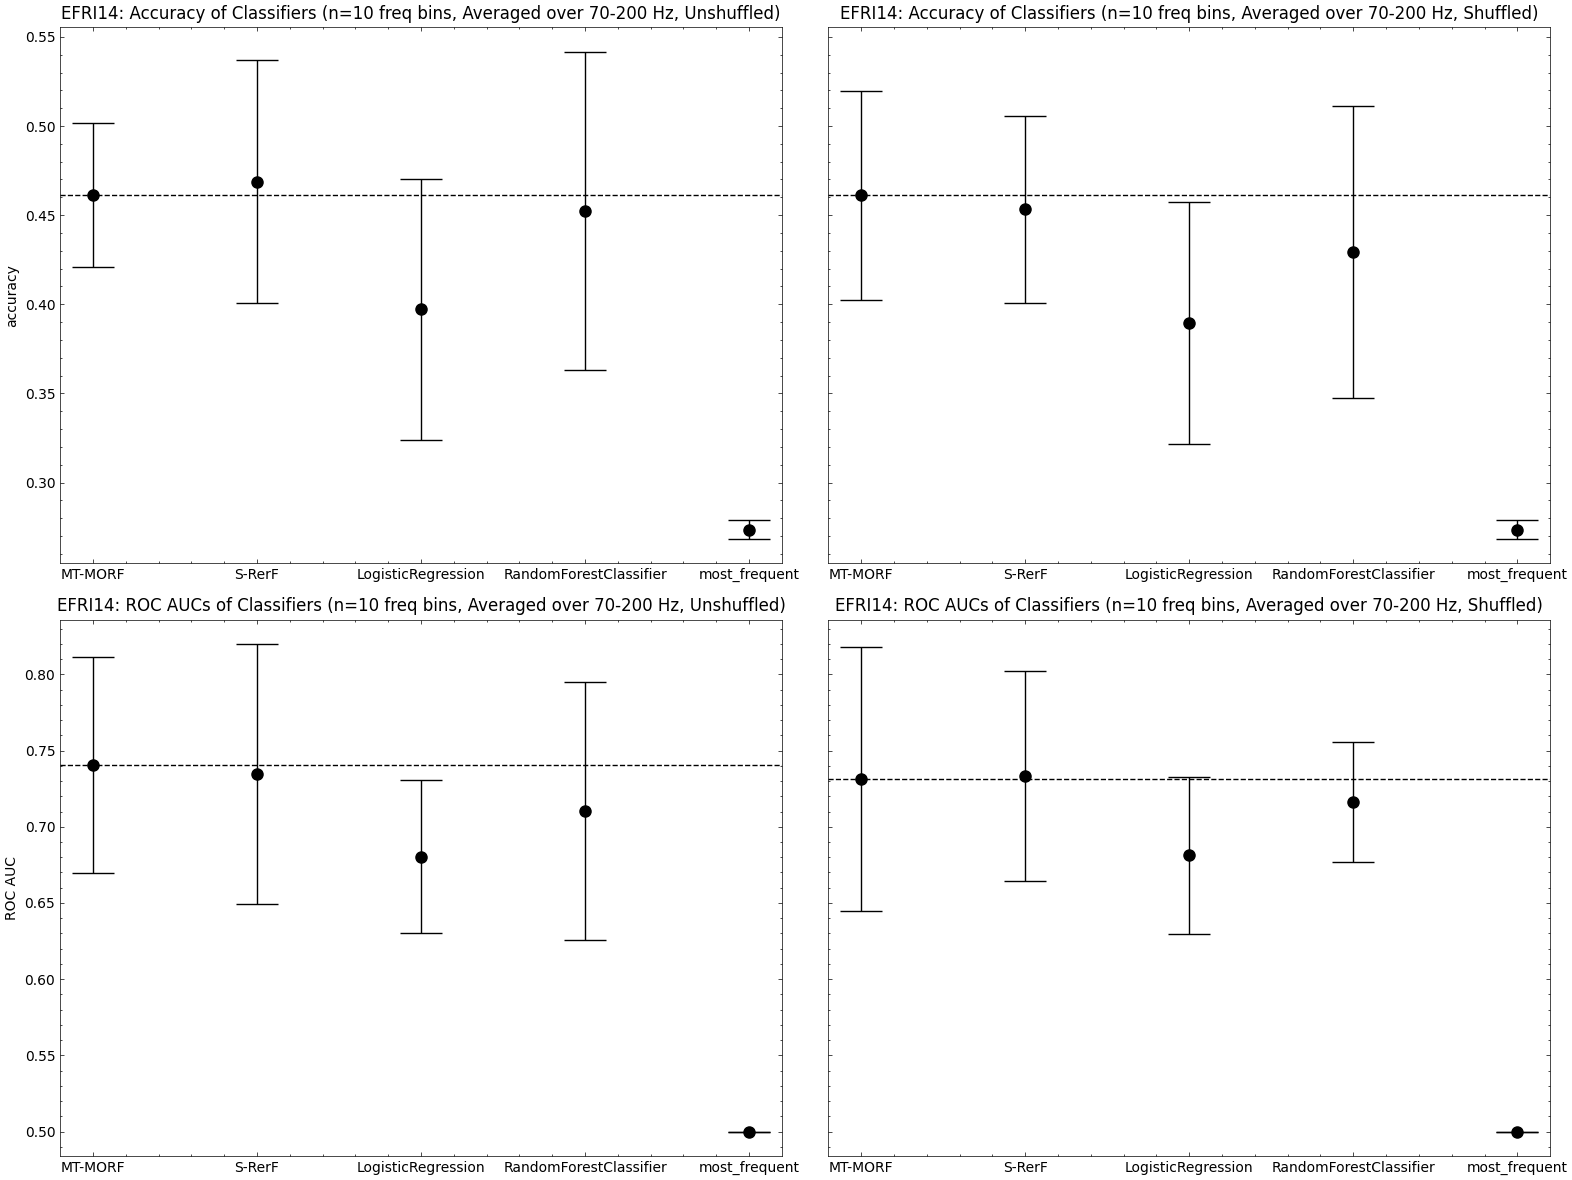

In [19]:
nfreqs = 10
lfreq, hfreq = (70, 200)

## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=False, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_accuracies(clf_scores_shuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, No Averaging)

Not setting metadata
Not setting metadata


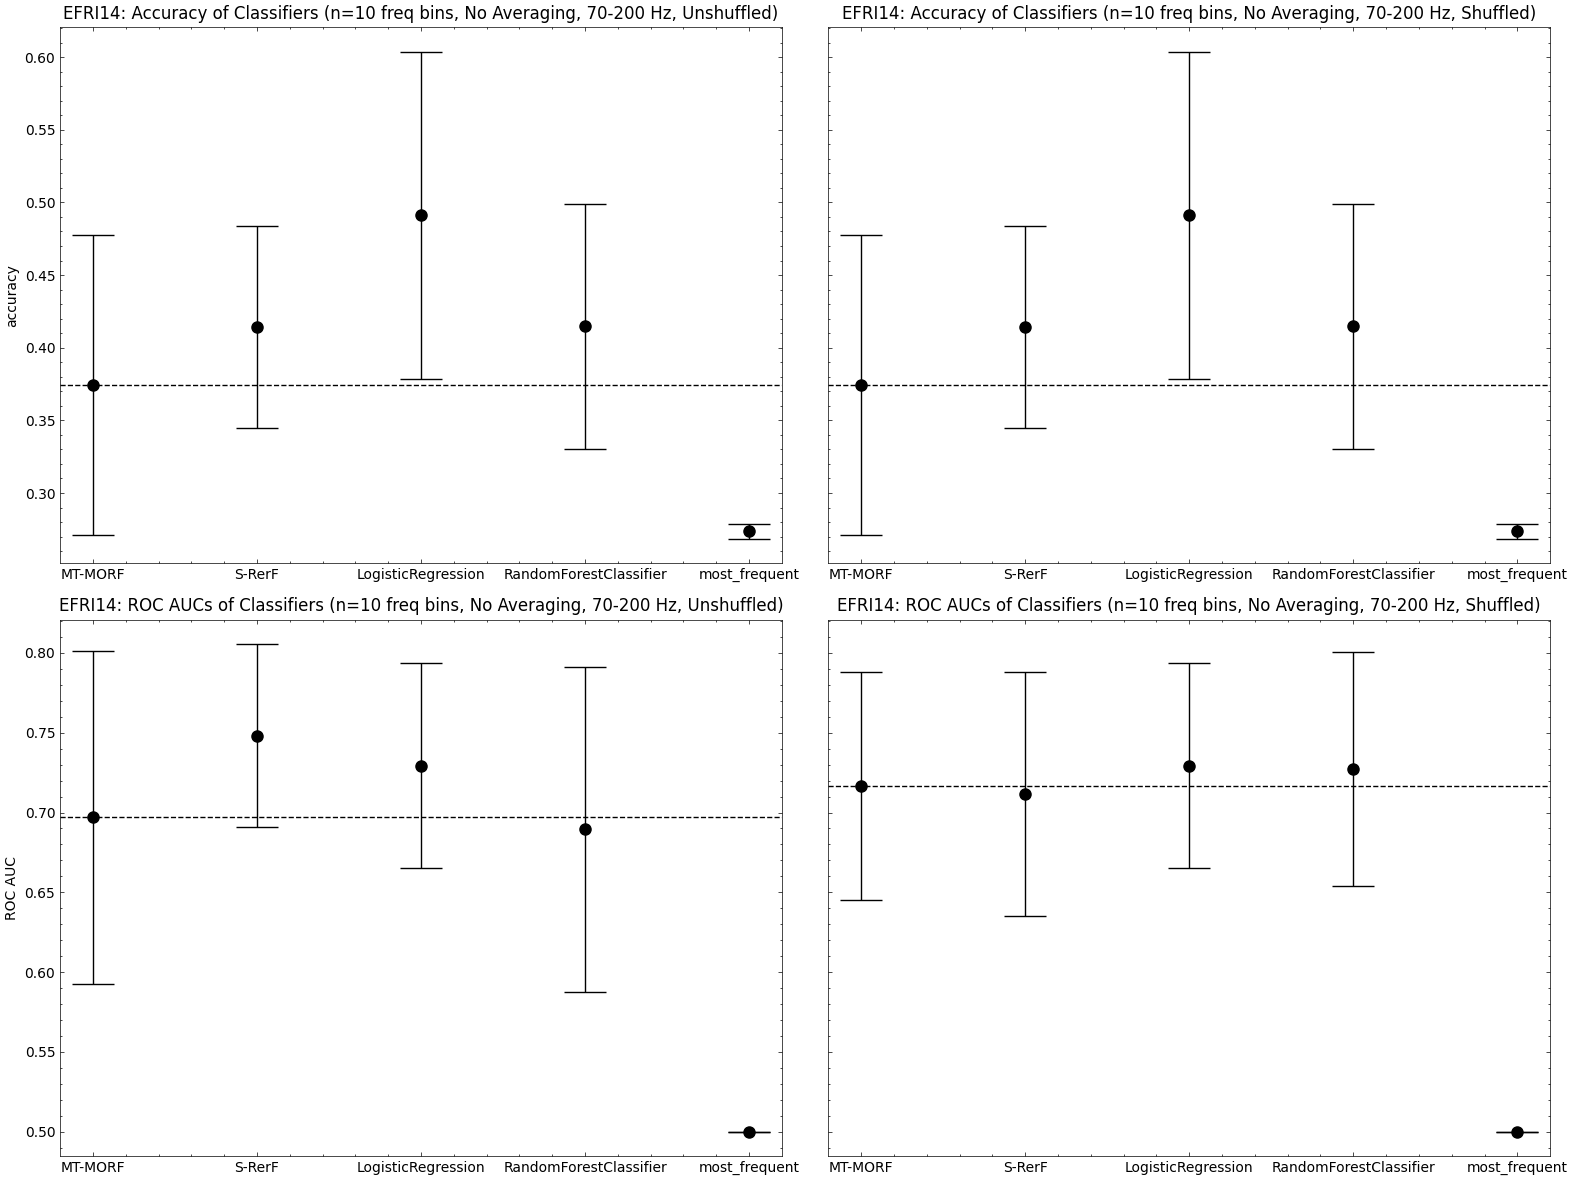

In [20]:
## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_accuracies(clf_scores_unshuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

## EFRI07

In [21]:
# subject identifiers
subject = "efri07"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [22]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in /Volumes/mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 98 trials, there were 96 successful trials in /Volumes/mac/research/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading /Volumes/mac/research/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=0.5/band-pass=1-1000Hz-downsample=500/efri07/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...     498.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95


In [23]:
bids_path = BIDSPath(subject=subject, session=session, task=task,
                    acquisition=acquisition, run=run, suffix=kind, extension=".tsv", root=bids_root)
bids_path.update(suffix="channels")
bads = _get_bad_chs(bids_path)

tmp = _from_tsv(bids_path)
tmp = [
    (name, anat) 
    for (name, anat) in zip(tmp["name"], tmp["anat"]) 
    if name not in bads
]

channels = pd.DataFrame(tmp, columns=["name", "anat"])
sorted_channels = channels.sort_values(["anat"])
sorted_channels.head()

name             anat
76  REF2               CZ
75  REF1               FZ
77     E               PZ
53    P8  angular gyrus R
54    P7  angular gyrus R

In [24]:
sorted_channels[sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")]

name                          anat
23   U2  insular cortex (posterior) R
24   U1  insular cortex (posterior) R
39   B7       middle temporal gyrus R
38   B8       middle temporal gyrus R
36  B10       middle temporal gyrus R
31   F8       middle temporal gyrus R
30   F9       middle temporal gyrus R
37   B9       middle temporal gyrus R

In [25]:
anat = sorted_channels["anat"].str.contains("insular cortex|central sulcus|middle temporal gyrus")
picks = list(sorted_channels[anat]["name"])
epochs_anat = epochs.pick_channels(picks)

In [26]:
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

### Shuffled vs Unshuffled (Time Domain)

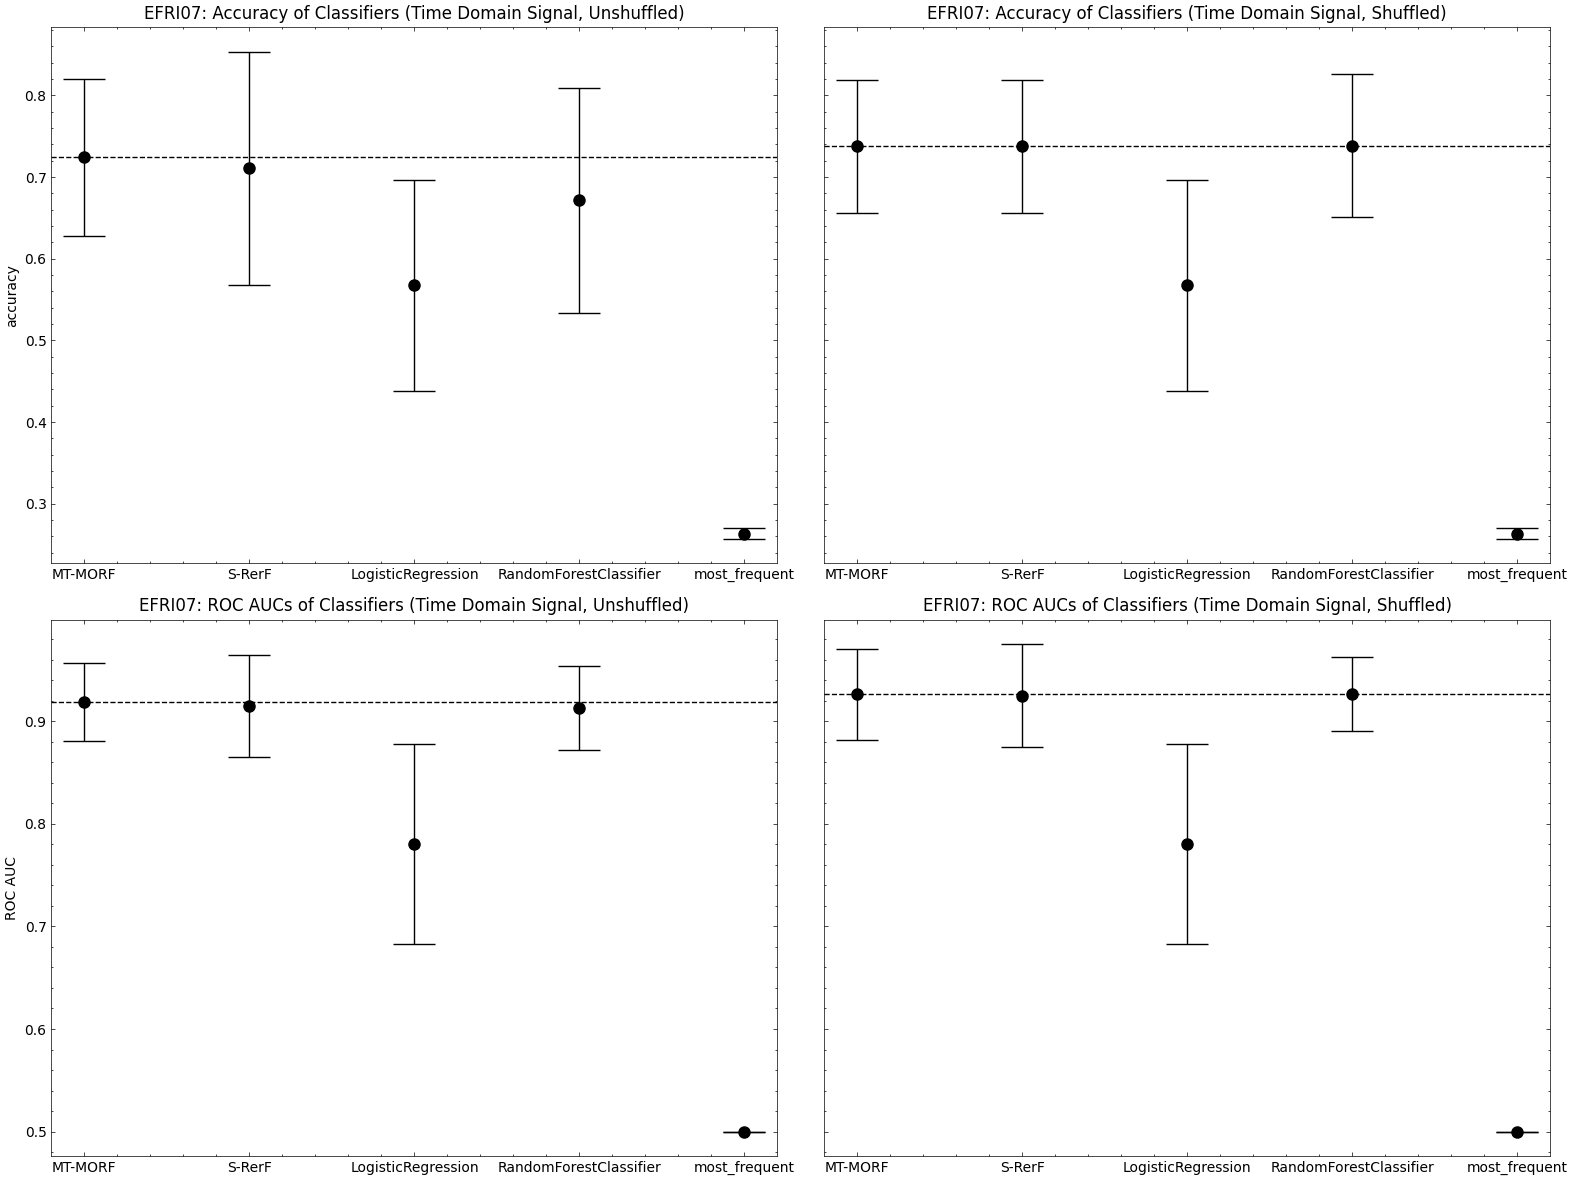

In [27]:
## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=False, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=False, shuffle_channels=True, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Unshuffled)")

plot_accuracies(clf_scores_shuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (Time Domain Signal, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (Time Domain Signal, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, Averaged)

Not setting metadata
Not setting metadata


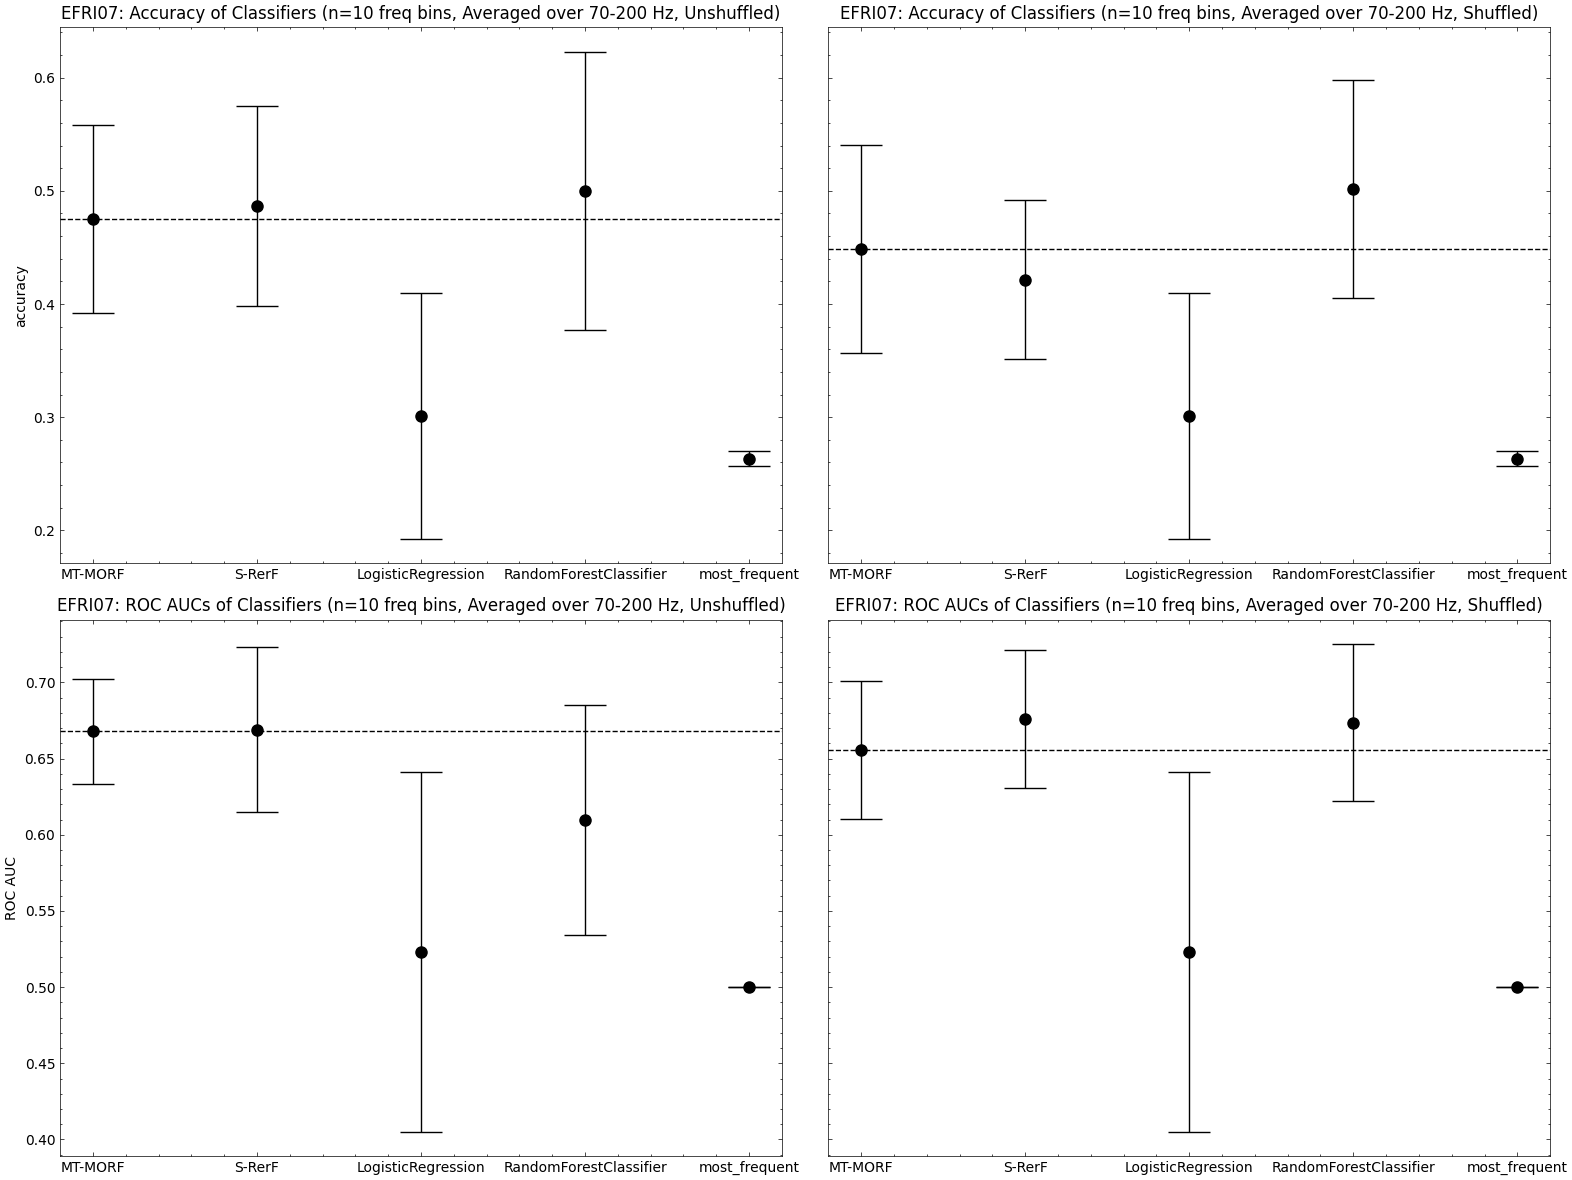

In [28]:
nfreqs = 10
lfreq, hfreq = (70, 200)

## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=False, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=True, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_accuracies(clf_scores_shuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, Averaged over {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();

### Shuffled vs Unshuffled (Freq Domain, No Averaging)

Not setting metadata
Not setting metadata


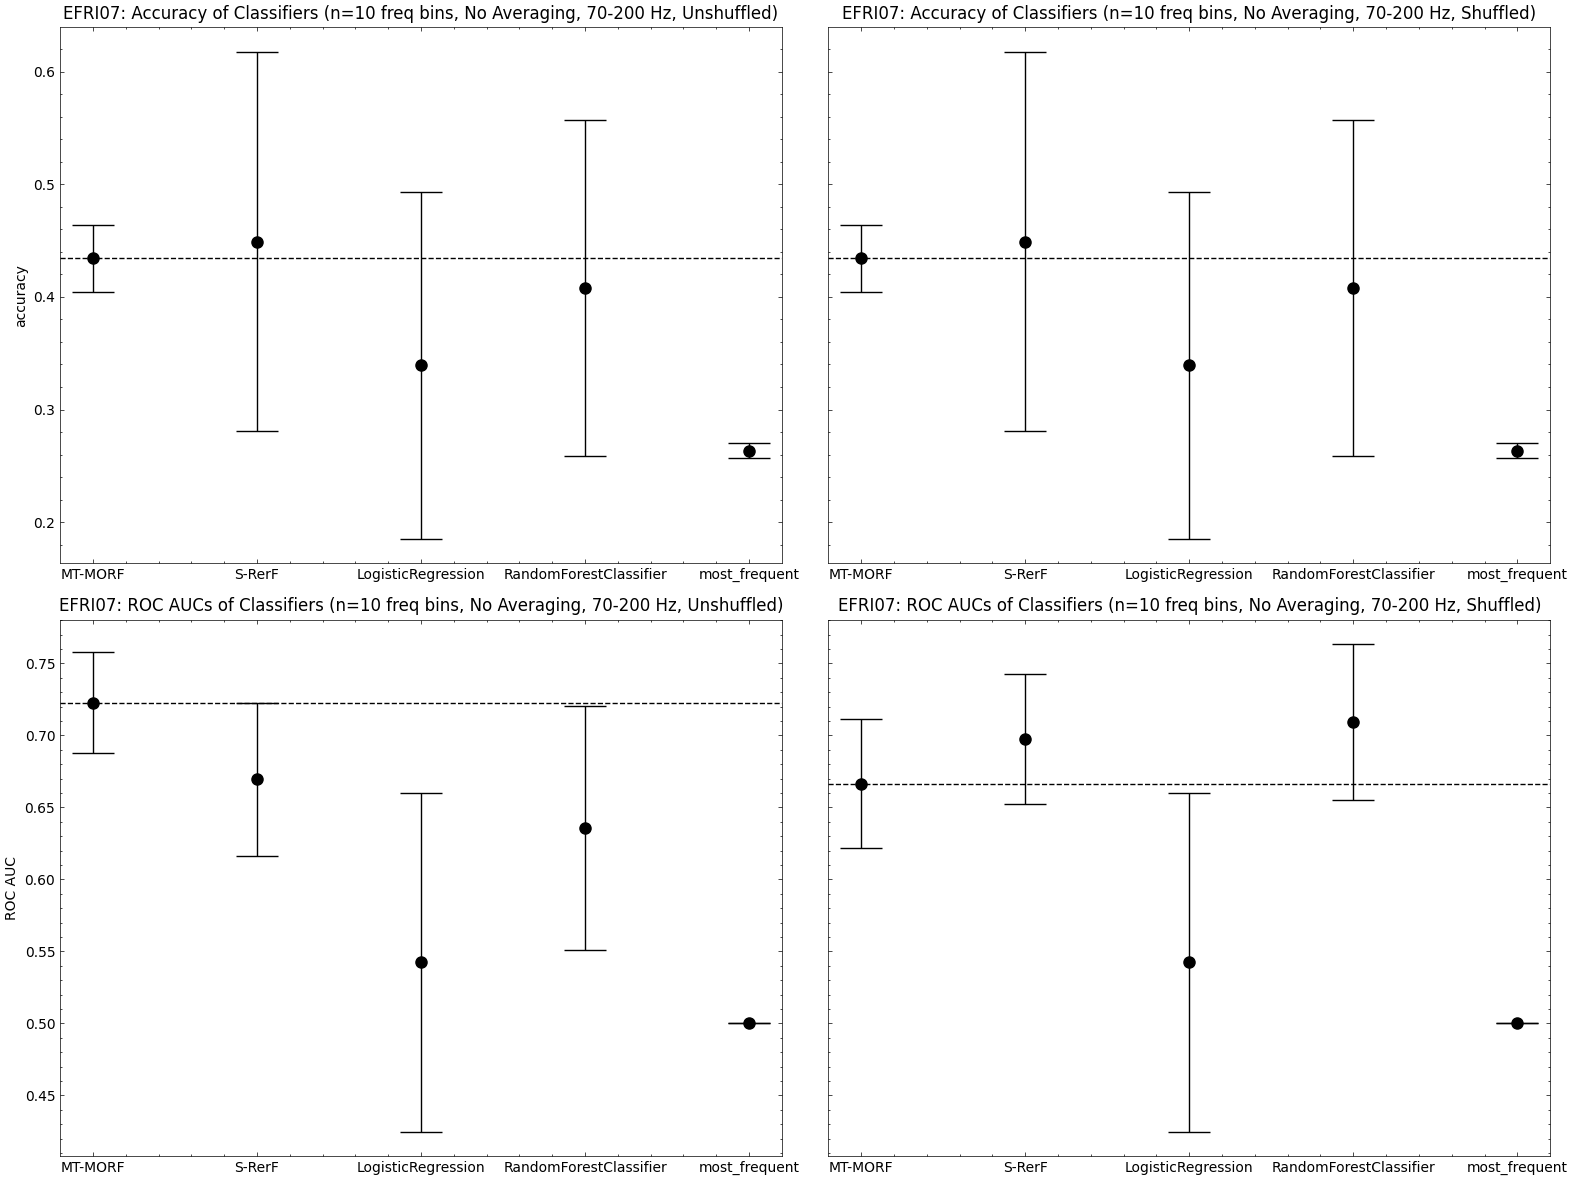

In [29]:
## Fit models
clf_scores_unshuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

clf_scores_shuffled = run_classifier_comparison(epochs_anat, labels, cv, freq_domain=True, shuffle_channels=True, avg_freq=False, nfreqs=nfreqs, lfreq=lfreq, hfreq=hfreq, random_state=rng)

## Plot results
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(16, 12), sharey="row")
axs = axs.flatten()

plot_accuracies(clf_scores_unshuffled, ax=axs[0])
axs[0].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_accuracies(clf_scores_unshuffled, ax=axs[1])
axs[1].set(title=f"{subject.upper()}: Accuracy of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Shuffled)")

plot_roc_aucs(clf_scores_unshuffled, ax=axs[2])
axs[2].set(ylabel="ROC AUC", title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Unshuffled)")

plot_roc_aucs(clf_scores_shuffled, ax=axs[3])
axs[3].set(title=f"{subject.upper()}: ROC AUCs of Classifiers (n={nfreqs} freq bins, No Averaging, {lfreq}-{hfreq} Hz, Shuffled)")

fig.tight_layout();